In [74]:
import time
from os.path import join, dirname, expanduser

import cv2
import torch
import torch.nn as nn
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor

from yolort.utils import Visualizer
from yolort.v5 import load_yolov5_model

from PIL import Image
import numpy as np

In [101]:
# Directory configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_cuda = False if str(device) == "cpu" else True
weights_blood_det_th = "../weights/torchscript/traced_blood_det_th-{}.pt".format(device).replace(":0","")
weights_blood_det_ir = "../weights/torchscript/traced_blood_det_ir-{}.pt".format(device).replace(":0","")

In [102]:
# Check model labels
weights_blood_det_ir_torch = "../weights/pytorch/yolov5_blood_det_ir.pt"
weights_blood_det_th_torch = "../weights/pytorch/yolov5_blood_det_th.pt"
model_yolov5_ir = load_yolov5_model(weights_blood_det_ir_torch)
model_yolov5_ir = model_yolov5_ir.to(device)
model_yolov5_ir = model_yolov5_ir.eval()

model_yolov5_th = load_yolov5_model(weights_blood_det_th_torch)
model_yolov5_th = model_yolov5_th.to(device)
model_yolov5_th = model_yolov5_th.eval()

print("IR model labels", model_yolov5_ir.names)
print("TH model labels", model_yolov5_th.names)

IR model labels {0: 'Blood_Background', 1: 'Blood_Skin'}
TH model labels {0: 'Cold_Background', 1: 'Cold_Body', 2: 'Warm_Background', 3: 'Warm_Body', 4: 'Warm_Dripping'}


In [103]:
print("Loading detection model...")
model_blood_det_th = torch.jit.load(weights_blood_det_th)
model_blood_det_ir = torch.jit.load(weights_blood_det_ir)
print("Detection models loaded successfully")

Loading detection model...
Detection models loaded successfully


In [104]:
# input data and transform
HOME = expanduser("~")
filename_th = join(HOME, "Downloads/slack_spectronix/investigate/thermal/16bit/2/fail_00001.png")
filename_ir = join(HOME, "Downloads/slack_spectronix/nausea/cam1_ir/test_00151.png")

img_th = cv2.imread(filename_th, cv2.IMREAD_ANYDEPTH)
img_ir = cv2.imread(filename_ir, cv2.IMREAD_ANYDEPTH)

In [113]:
# input data and transform
HOME = expanduser("~")
filename_th = join(HOME, "Downloads/slack_spectronix/nausea/cam1_th/test_00151.png")
filename_ir = join(HOME, "Downloads/slack_spectronix/nausea/cam1_ir/test_00151.png")

img_th = cv2.imread(filename_th, cv2.IMREAD_ANYDEPTH)
img_ir = cv2.imread(filename_ir, cv2.IMREAD_ANYDEPTH)

In [114]:
# input data and transform
HOME = expanduser("~")
filename_th = join(HOME, "Datasets/spectronix/thermal/blood/16bit/s01_thermal_cloth_01_MicroCalibir_M0000334/0001.png")
filename_ir = join(HOME, "Datasets/spectronix/ir/blood/16bit/s01_thermal_cloth_01_000028493212_ir/0001.png")

img_th = cv2.imread(filename_th, cv2.IMREAD_ANYDEPTH)
img_ir = cv2.imread(filename_ir, cv2.IMREAD_ANYDEPTH)

In [115]:
def sixteen_bits2eight_bits(pixel, max_value):
    # Pseudo colouring the 16 bit images
    pixel = (pixel - np.min(pixel)) / (max_value-np.min(pixel))
    pixel = np.rint(pixel * 255)
    return pixel.astype("uint8")

In [116]:
# conversion
img_th = sixteen_bits2eight_bits(img_th, max_value=30100)
img_ir = sixteen_bits2eight_bits(img_ir, max_value=395)# conversion

In [117]:
# conversion
img_prc_th = img_th
img_prc_th = cv2.cvtColor(img_prc_th, cv2.COLOR_GRAY2BGR)
img_prc_th = img_prc_th.astype("float32") / 255.
ts_img_th = torch.as_tensor(img_prc_th.transpose(2,0,1)).to(device)
ts_img_th = ts_img_th.unsqueeze(0)

img_prc_ir = img_ir
img_prc_ir = cv2.cvtColor(img_prc_ir, cv2.COLOR_GRAY2BGR)
img_prc_ir = img_prc_ir.astype("float32") / 255.
ts_img_ir = torch.as_tensor(img_prc_ir.transpose(2,0,1)).to(device)
ts_img_ir = ts_img_ir.unsqueeze(0)

In [108]:
# dry run
for i in range(3):
    model_blood_det_th(ts_img_th)
    model_blood_det_ir(ts_img_ir)

In [118]:
with torch.no_grad(): #ensures autograd is off
    out_bdet_th = model_blood_det_th(ts_img_th)
    out_bdet_ir = model_blood_det_ir(ts_img_ir)

In [119]:
print("Output bdet th:", out_bdet_th[1][0])
print("Output bdet ir:", out_bdet_ir[1][0])

Output bdet th: {'scores': tensor([0.85037, 0.68122], device='cuda:0'), 'labels': tensor([0, 1], device='cuda:0'), 'boxes': tensor([[446.12079, 334.78857, 492.60687, 443.46326],
        [187.64420, 286.04163, 246.93088, 357.55853]], device='cuda:0')}
Output bdet ir: {'scores': tensor([], device='cuda:0'), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'boxes': tensor([], device='cuda:0', size=(0, 4))}


In [120]:
def visualize(image, normalize=False):

    if normalize:
        image = cv2.normalize(image, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) 

    # rescale (16-bit image only) see method 2 https://answers.opencv.org/question/207313/conversion-16bit-image-to-8-bit-image/
    if (image.dtype) == np.uint16:
        image = image / 257
        image = image.astype(np.uint8)

    #cv2.normalize(image, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) 
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

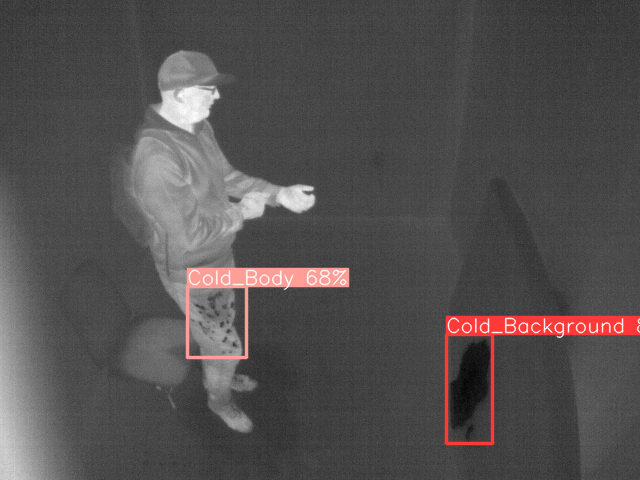

In [121]:
# verify results
img_raw_th = cv2.imread(filename_th, cv2.IMREAD_ANYDEPTH) #original
v = Visualizer(visualize(img_prc_th, True), ["Cold_Background", "Cold_Body", "Warm Background", "Warm_Body", "Warm_Dripping"])
v.draw_instance_predictions(out_bdet_th[1][0])
v.imshow(scale=1.0)

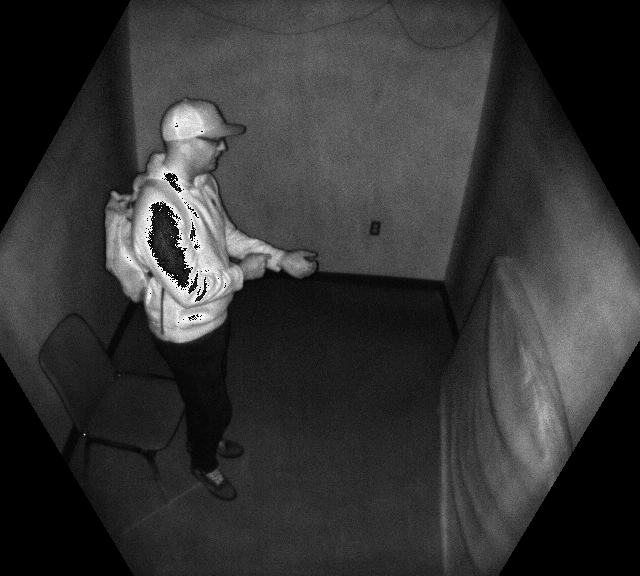

In [122]:
# verify results
img_raw_ir = cv2.imread(filename_ir, cv2.IMREAD_ANYDEPTH) #original
#v = Visualizer(visualize(img_prc_ir, True), ["Cold_Background", "Cold_Body", "WB", "Warm_Body", "Warm_Dripping"])
v = Visualizer(visualize(img_prc_ir, True), ["Blood_Background", "Blood_Skin"])
v.draw_instance_predictions(out_bdet_ir[1][0])
v.imshow(scale=1.0)

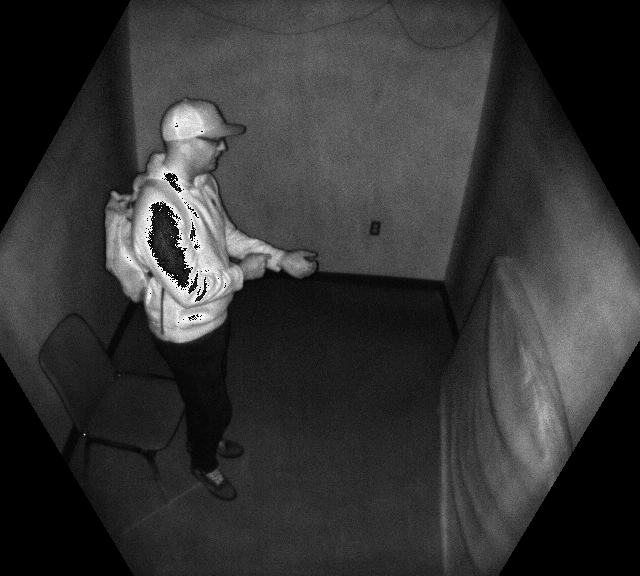

In [90]:
# verify results
img_raw_ir = cv2.imread(filename_ir, cv2.IMREAD_ANYDEPTH) #original
#v = Visualizer(visualize(img_prc_ir, True), ["Cold_Background", "Cold_Body", "WB", "Warm_Body", "Warm_Dripping"])
v = Visualizer(visualize(img_prc_ir, True), ["Blood_Background", "Blood_Skin"])
v.draw_instance_predictions(out_bdet_ir[1][0])
v.imshow(scale=1.0)